# Coursework Assignment: Text classification

## (1) : Introduction

### Domain-Specific Area : Movie and Film Industry

This report aims to explore how the application of a text classifier for sentiment analysis can help resolve challenges in the Film Industry. With the ever-growing popularity of social media and review websites, it has grown increasingly difficult to make informed decisions regarding whether a movie is worth watching.

This is due to a simple fact that peoples' taste in films will differ significantly. The uncertainity regarding how worth new movies are to watch could lead to having a fear of missing out(FOMO).

Furthermore, with the rising costs in our day-to-day lives, deciding to spend a night at the cinema is a very costly affair. It is a terrible experience for any individual to have to spend $15 SGD, just to have it wasted on a film of subpar quality for the next few hours of the evening.

By creating a text classifier to analyze sentiment in movie reviews, this report hopes to aid indivisuals in their decision making and improve the quality of their movie-watching experience.

### Objectives

The main problem this report tackles is being able to get a text classifier that identifies the overall sentiment of a given movie's reviews.

Thus, the primary objective of this classifier is to,

- Correctly assign binary labels of pos/neg to movie reviews.

### Dataset

For the dataset, I will be using the <a href="https://ai.stanford.edu/~amaas/data/sentiment/"><b>Large Movie Review Dataset</b></a> which was the dataset used in the publication of the ACL 2011 paper, <b>Learning Word Vectors for Sentiment Analysis</b>, written by <b>Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang,
Andrew Y. Ng, and Christopher Potts</b>, which can be found <a href="https://aclanthology.org/P11-1015/">here</a>.

This dataset contains a wide collection of movie reviews that is meant for use with binary sentiment classification.

It contains data on a total of 100 thousand movie reviews, being split into a set of 25 thousand reviews for training and testing, with an additional 50 thousand unlabelled data meant for unsupervised learning.

As the objective of this text classifier is the assignment of binary labels to each review, the report will not be taking the unlabelled reviews into consideration as the objective of this classifier is a supervised task.

The dataset has been split into 2 main directories, one each for both labelled test set and training sets. Both sets are further split into 2 sub-folders, one housing positive review data and the other housing negative review data.

Each movie review is stored in a .txt file with the naming format of <b>[id]_[rating].txt</b>. A negative rating is a review on IMDB with a score of ≤ 4, whereas a positive review will have a score of at least a 7, both on the scale of 10. For each set, reviews that scored a 5 or 6 were not included due to the neutrality/ambiguity of said review.

This data was web scraped from IMDB's website, with each movie scraped via its unique ID web page and unique URL included in the dataset as well, under the test/train folders in a urls.txt file.

### Evaluation Methodology

For our objective of training a text classifier to be able to properly analyse the overall sentiment of a movie through its reviews in order for users to gauge if a movie is worth their time, these are a some evaluation metrics that can be taken into consideration.

<b>Precision</b>
The precision of a model can be understood as the measure of predicted positives out of the actual positives. The formula for this is,

$$ Precision = {True Positive(TP) \over True Positive(TP) + False Positive(FP)} $$

<b>Recall</b>
The Recall of a model can be understood as the measure of correctly identified true positives. The formula for this is,

$$ Recall = {True Positive(TP) \over True Positive(TP) + False Negative(FN)} $$

<b>F-1 Score</b>
The F-1 Score/Measure can be understood as the harmonic mean of both the precision and recall. The formula for this is,

$$ F1 = 2 * {Precision(P) * Recall(R) \over Precision(P) + Recall(R)} $$

Given these 3 evaluation metrics and our objective of being able to help users gauge if a movie is worth the time invested, I have chosen to focus on having a <b>higher</b> recall in my model as this will allow it to capture as much positive/negative sentiments that have been written in a movie's reviews.

This can be understood by the example, <i>of all the movies listed as being good, how many of them have been correctly classified by our model</i>.

Besides focusing on just a higher recall, another key metric we will be looking at is a variation of the F-Score, known as the <b>F-2 Score</b>.

While the F-1 Score weighs both the Precision and Recall rate equally, the F-2 Score puts a <b>larger emphasis</b> on the recall. The formula for this is,

$$ F2 = 5 ( {Precision(P) * Recall(R) \over ((4 * Precision(P)) + Recall(R)} ) $$

In conclusion, I have chosen to focus on the F-2 Score to evaluate the performance of my model due to the fact that the recall rate is given a higher emphasis, which suits the primary objective of my classifier.

## (2) : Implementation

### Data Retrieval

For the first step, we will preprocess the dataset that i have stored locally on my machine.

In [2]:
#Importing the relevant libraries
import sys
import re
import nltk
import os
import pandas as pd
import numpy as np
import glob

import gensim
from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Owen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Owen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# ParseReview function - Add each review in text files to a list
# before we add them to a new dataframe
def parseReviews(file_list):
    review_list = []

    for file in file_list:
        with open(file, 'r', encoding='utf-8') as review:
            content = review.read()
            review_list.append(content)
            
    return review_list

# getFilmScores function - Tokenise the full path of each file and extract the score ?/10
# Example: "dataset/train/neg\0_3.txt"
# Tokenise on "\\" -> 'dataset/train/neg', '0_3.txt'
# Tokenise on "_" -> '0', '3.txt'
# Tokenise on "." -> '3', '.txt'
# Film has a score of 3 on the scale of 10
def getFilmScores(file_list):
    score_list = []

    for file in file_list:
        file_name = file.split('\\')
        file_tokens = file_name[1].split('_')
        file_score = file_tokens[1].split('.')

        score_list.append(file_score[0])
        
    return score_list

In [5]:
# Use pandas .read_csv function to read the .txt files in specified directory
directory = "dataset/train/neg"

# Use the glob module to find all pathnames that match the directory
file_list = glob.glob(directory + "/*.txt")

### Data Snapshot(s)

In [6]:
# Call parseReviews function and add the contents of the list to a dataframe
review_list = parseReviews(file_list)

# Call getFilmScores function to add film score (?/10) to a list and to the dataframe
score_list = getFilmScores(file_list)

# Assign a binary label to each row (neg/pos)
neg_reviews = pd.DataFrame({'review_content': review_list, 'film_score': score_list, 'sentiment': "neg"})

# Sanity check of top 20 rows
neg_reviews[:20]

,review_content,film_score,sentiment
0,Story of a man who has unnatural feelings for ...,3,neg
1,Airport '77 starts as a brand new luxury 747 p...,4,neg
2,This film lacked something I couldn't put my f...,4,neg
3,"Sorry everyone,,, I know this is supposed to b...",1,neg
4,When I was little my parents took me along to ...,1,neg
5,"""It appears that many critics find the idea of...",3,neg
6,The second attempt by a New York intellectual ...,3,neg
7,"I don't know who to blame, the timid writers o...",4,neg
8,This film is mediocre at best. Angie Harmon is...,1,neg
9,The film is bad. There is no other way to say ...,2,neg


In [7]:
# Repeat for the positive reviews in our training set
directory = "dataset/train/pos"

file_list = glob.glob(directory + '/*.txt')

In [8]:
review_list = parseReviews(file_list)
score_list = getFilmScores(file_list)
pos_reviews = pd.DataFrame({'review_content': review_list, 'film_score': score_list, 'sentiment': "pos"})

pos_reviews[:20]

,review_content,film_score,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,9,pos
1,Homelessness (or Houselessness as George Carli...,8,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,pos
3,This is easily the most underrated film inn th...,7,pos
4,This is not the typical Mel Brooks film. It wa...,8,pos
5,"This isn't the comedic Robin Williams, nor is ...",8,pos
6,Yes its an art... to successfully make a slow ...,7,pos
7,"In this ""critically acclaimed psychological th...",7,pos
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,7,pos
9,"You know, Robin Williams, God bless him, is co...",7,pos


### Dataframe size comparison

Although we know from the README that came with the dataset that the data should be even, we can create a simple bar chart to compare the number of positive and negative reviews to confirm that it is in fact true.

I will be using the built-in functions from pandas to plot a simple bar chart for comparison.

<module 'matplotlib.pyplot' from 'C:\\Users\\Owen\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

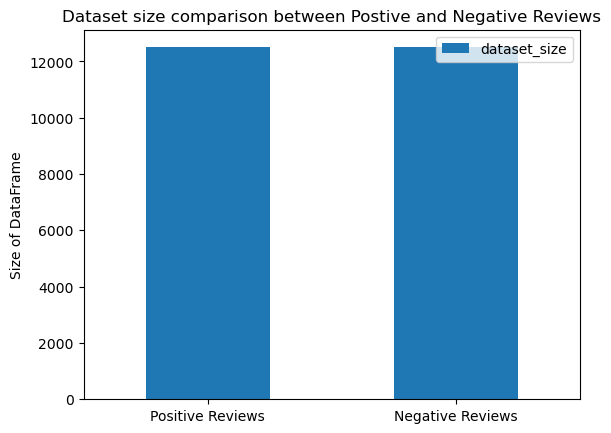

In [9]:
barplot = pd.DataFrame(
    {"dataset_size": [len(pos_reviews.index), len(neg_reviews.index)]},
        index=["Positive Reviews", "Negative Reviews"])

barplot.plot(kind="bar")
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Dataset size comparison between Postive and Negative Reviews")
plt.ylabel("Size of DataFrame")  

# display bar chart
plt

As can be seen above, both pos/neg review dataframes have the same size of 12500 and thus have an equal representation in the dataset.

A balanced dataset ensures that that is no biasness towards either end in our data and that there is fair treatment to all our classes.

### Preprocessing

Now that we have taken a look at the dataframes, I will be converting the words within the <b>postive</b> and <b>negative</b> DataFrames into a <b>Continuous Bag of Words(CBoW)</b> format.

The reason for this over a normal Bag Of Words(BoW) for example, is due to contextual information being important in each review, a BoW does not consider the sequence of words and each of them are treated independently. However, a CBoW does the opposite, taking into account word order and context, which is important for our binary classification.

I have chosen to use the Word2Vec algorithm from the gensim module to represent my CBoW.

But, before I can do so, there is preprocessing to the text that must be done.

The steps I will take to prepare my text are,
- Tokenization,
- Stopword Removal,
- Removal of special characters and numbers,
- Text Lowercasing,
- Lemmatization,
- Feature Scaling.

Both lemmatization and stemming were considered in preprocessing, with lemmatization ultimately being chosen. Since the context of words in the review are a major factor in keeping the the core meaning and sentiment, i have opted to use lemmatization instead.

In [10]:
# Preprocess review content with steps mentioned above (tokenization, stopword removal etc.)
def preprocess_text_data(text_content):
        # Initialize lemmatizer
        lemma = WordNetLemmatizer()
        # Use regex to remove special characters and integers
        text_content = re.sub('[^a-zA-Z]', ' ', text_content)

        # Transform characters to lowercase and tokenize them
        text_content = text_content.lower()
        w_tokens = word_tokenize(text_content)

        # Lemmative tokenized words to extract root meaning of word
#         lw_tokens = [lemma.lemmatize(w_token) for w_token in w_tokens]
        
        # run remove stop words function
        preprocessed_text = stop_words_removal(w_tokens)

        return preprocessed_text

    
# Remove english stop words from the reviews to increase search performance
def stop_words_removal(text_content):
    # Remove stop words in text content
    stop_words = set(stopwords.words('english'))
    fil_tokens = tokens_without_sw = [word for word in text_content if not word in stop_words]
    
    # Re-append the cleaned/filtered content into a string
    fil_string = ' '.join(fil_tokens)
    return fil_string

### Data Splitting

Before any training is done, the data will also be shuffled so as to avoid any sequential bias and also promote fairness across data by preventing the model from learning to rely on specific order of examples.

Of the 25 thousand total reviews in both the training and testing sets, I will split them in the ratio of <b>[80 : 20]</b>. 80% for data training from the training set and 20% for data testing from the testing set, all chosen at random by shuffling the entries as mentioned previously.


The identified features of this classifier are the 'review_content' and the identified labels will be the 'sentiment'.

In [11]:
# Create new dataframe for text preprocessing
processed_df = pd.DataFrame()


# Append entries from each to the DataFrame for splitting/shuffling
processed_df = pd.concat([pos_reviews, neg_reviews])

# Shuffle entries and update indices
processed_df = shuffle(processed_df)
processed_df.reset_index(inplace=True, drop=True)

# Split features and label
x_data_features = processed_df['review_content']
y_data_labels = processed_df['sentiment']

In [12]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_content  25000 non-null  object
 1   film_score      25000 non-null  object
 2   sentiment       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [14]:
# Split data using 80 : 20 ratio (training : testing)
X_train, X_test, y_train, y_test = train_test_split(x_data_features, y_data_labels, test_size=0.20, random_state=1)

# ratio should be 20000 training data and 5000 testing data.
print('Split Dataset size(s)')
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

Split Dataset size(s)
X_train:  (20000,)
X_test:  (5000,)
y_train:  (20000,)
y_test:  (5000,)


In [15]:
X_train_df = pd.DataFrame()

X_train_df['processed_review'] = X_train.apply(preprocess_text_data)
X_train_df = X_train_df['processed_review'].tolist()

In [17]:
# Tokenize the preprocessed reviews
tokenized_reviews = [word_tokenize(review) for review in X_train_df]

# Train the Word2Vec model (CBoW)
cbow_model = Word2Vec(sentences = tokenized_reviews, min_count = 1, vector_size = 100, workers = 6, window = 5, cbow_mean = 1)

# Get the dimensionality of our CBoW Model, needed when we are training our SVM Classifier
n_features = cbow_model.vector_size
print("Number of Features: ", n_features)

Number of Features:  100


### Baseline Performance/Model

For the baseline model, a <b>Logistic Regression</b> model was used with the existing CBoW text representation we created during our preprocessing.

Logistic Regression was chosen as the baseline as,
- it is one of the easier models to implement and train,
- it is one of the most efficient models when outcomes have linearly separable distinctions.

The steps to accomplish this are,
- generate word vectors from the CBoW model we created,
- init and train Logistic Regression model using sckit-learn,
- make predictions of the baseline,
- evaluate metrics of the model

In [18]:
# import sklearn modules for use of logistic regression and its features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

### Word Vectors

In [19]:
# Create Word Vector based on training set
X_train_word_vector = np.array([np.mean([cbow_model.wv[word] for word in review], axis=0) for review in tokenized_reviews])

A similar line of code was used to create a word vector based on the 20% X_test data, but a ValueError was encountered as Python was attempting to assign the whole sequence to the X_test_word_vector array.

The solution for this was to create an empty numpy array in the shape of the proposed word vector, "dataset length * vector_size". 

In [20]:
# Create Word Vector based on testing set
X_test_word_vector = np.zeros((len(X_test), 100))

# 
for i, review in enumerate(X_test):
    word_vectors = [cbow_model.wv[word] for word in review.split() if word in cbow_model.wv]
    if word_vectors:
        mean_vector = np.mean(word_vectors, axis=0)
        X_test_word_vector[i] = mean_vector

In [35]:
baseline_clf = LogisticRegression(max_iter=300)
baseline_clf.fit(X_train_word_vector, y_train)

LogisticRegression(max_iter=300)

In [37]:
y_pred = baseline_clf.predict(X_test_word_vector)

In [38]:
precision = precision_score(y_test, y_pred, pos_label='pos')
recall = recall_score(y_test, y_pred, pos_label='pos')

As finding the F2 Score is not an existing function in the sklearn module, we will be calculating it using the aforementioned formula,

$$ F2 = 5 ( {Precision(P) * Recall(R) \over ((4 * Precision(P)) + Recall(R)} ) $$

In [33]:
def find_f2_score(precision, recall):
    f_two = 5 * (precision * recall / ((4 * precision) + recall))
    
    return f_two

f2_score = find_f2_score(precision, recall)


### Performance of the Logistic Regression Model (Baseline)

In [39]:
print("===Logistic Regression Evaluation Metrics===")
print('Precision: ', precision, '%')
print('Recall: ', recall, '%')
print('F2-Score: ', f2_score, '%')

===Logistic Regression Evaluation Metrics===
Precision:  0.8188795088257866 %
Recall:  0.8362068965517241 %
F2-Score:  0.8326830029655065 %


### Classification Approach

For our approach, a <b>Support Vector Machine</b> classifier will be used and compared to the baseline.

The justification behind this is that,
- SVM works better with unstructured and semi-structured data such as text, while logistic regression requires independent variables that have already been identified.
- SVM is much less vulnerable to overfitting compared to logistic regression.
- SVM is deterministic, while logistic regression is probalistic

Sources:
- <a href="https://www.geeksforgeeks.org/differentiate-between-support-vector-machine-and-logistic-regression/">Differentiate between Support Vector Machine and Logistic Regression</a>
- <a href="https://obgyn.onlinelibrary.wiley.com/doi/pdf/10.1002/uog.2791">Support vector machines versus logistic regression: improving prospective performance in
clinical decision-making</a>

In [40]:
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# Initialise swm classifier from sklearn toolkit
svm_clf = svm.SVC(kernel='linear')

# Create a TF-IDF Vectorizer, SVM requires words to be stored as numerical features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf_vector = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf_vector = tfidf_vectorizer.transform(X_test)

# Fit SVM model according to given training data
svm_clf.fit(X_train_tfidf_vector, y_train)

SVC(kernel='linear')

In [42]:
# Predict the sentiment labels for the test data
y_pred = svm_clf.predict(X_test_tfidf_vector)

In [43]:
# Evaluate the performance of the classifier
precision = precision_score(y_test, y_pred, pos_label='pos')
recall = recall_score(y_test, y_pred, pos_label='pos')
f2_score = find_f2_score(precision, recall)

In [44]:
print("===Support Vector Machine Evaluation Metrics===")
print('Precision: ', precision, '%')
print('Recall: ', recall, '%')
print('F2-Score: ', f2_score, '%')

===Support Vector Machine Evaluation Metrics===
Precision:  0.8885044213763937 %
Recall:  0.905564263322884 %
F2-Score:  0.9021000858771175 %
